In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/submission.csv
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/train.csv
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/ef476be214d4.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/17f6c7072f61.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/8d13c46e7d75.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/be68322c7223.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/88e4399d207c.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/77ab222bf85c.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/61d9c88a3a4b.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/8448af27ba07.png
/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/test/388f12e8df0b.png
/kaggle/input/diabetic-retinopathy-classification-3

In [2]:
df = pd.read_csv('/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/train.csv')


In [3]:
df.head()

,id_code,diagnosis
0,c1e6fa1ad314,1
1,ed246ae1ed08,4
2,4d3de40ced3a,0
3,ae8472f8d310,1
4,3c28fd846b43,0


In [4]:
# import cv2
# import matplotlib.pyplot as plt

# image_id = df.loc[0, 'id_code']
# #{image_id}.png 
# #/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/train/60eeae3ba23d.png
# image_path = f'/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina/train/{image_id}.png'

# image = cv2.imread(image_path)

# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(image)
# plt.title(f'Diagnosis: {df.loc[0, "diagnosis"]}')
# plt.axis('off')
# plt.show()


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout ,Activation
from tensorflow.keras.applications import EfficientNetB3


2025-05-23 11:07:33.250724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747998453.479956      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747998453.548622      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(-0.5, 482.5, 346.5, -0.5)

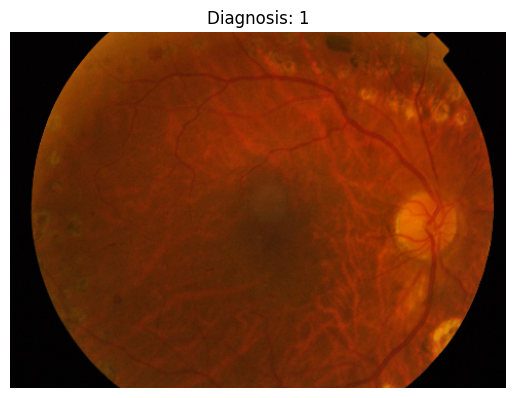

In [6]:
# Display a sample image from the Diabetic Retinopathy dataset
BASE_PATH = '/kaggle/input/diabetic-retinopathy-classification-3/kaggle_retina'
CSV_PATH = f'{BASE_PATH}/train.csv'
IMG_DIR = f'{BASE_PATH}/train'

df_preview = pd.read_csv(CSV_PATH)
if 'image_id' in df_preview.columns:
    df_preview.rename(columns={'image_id': 'id_code'}, inplace=True)

sample_id = df_preview.loc[0, 'id_code']
sample_label = df_preview.loc[0, 'diagnosis']
img_path = f"{IMG_DIR}/{sample_id}.png"

img = image.load_img(img_path)
plt.imshow(img)
plt.title(f"Diagnosis: {sample_label}")
plt.axis('off')

In [7]:
# BASE_PATH = '/kaggle/input/diabetic-retinopathy-classification-3'
# CSV_PATH = f'{BASE_PATH}/train.csv'
# IMG_DIR = f'{BASE_PATH}/train_images'

df = pd.read_csv(CSV_PATH)

# Ensure columns have consistent names
if 'image_id' in df.columns:
    df.rename(columns={'image_id': 'id_code'}, inplace=True)

df['filename'] = df['id_code'].apply(lambda x: f"{x}.png")

# train/validation split
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['diagnosis']
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=15,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw'
)

val_set = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMG_DIR,
    x_col='filename',
    y_col='diagnosis',
    target_size=(224, 224),
    batch_size=32,
    class_mode='raw',
    shuffle=False
)


Found 1757 validated image filenames.
Found 440 validated image filenames.


In [8]:
training_set.image_shape

(224, 224, 3)

In [9]:
base_model = EfficientNetB3(include_top=False, weights='imagenet', input_shape=(224, 224, 3), pooling='avg')
base_model.trainable = False  # Freeze base layers

model = Sequential([
    base_model,
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(5, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1747998468.890042      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747998468.890780      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)          │ (None, 1536)                │      10,783,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         393,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,178,292 (42.64 MB)

 Trainable params: 394,757 (1.51 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [10]:
history = model.fit(
    training_set,
    epochs=10,
    validation_data=val_set
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1747998498.810992     101 service.cc:148] XLA service 0x79d81421d840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747998498.812026     101 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747998498.812051     101 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747998501.898123     101 cuda_dnn.cc:529] Loaded cuDNN version 90300


 2/55 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.2500 - loss: 1.5679  

I0000 00:00:1747998518.048317     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


55/55 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.4224 - loss: 1.3985 - val_accuracy: 0.4932 - val_loss: 1.3013
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.4944 - loss: 1.3053 - val_accuracy: 0.4932 - val_loss: 1.3000
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 466ms/step - accuracy: 0.4865 - loss: 1.3160 - val_accuracy: 0.4932 - val_loss: 1.2900
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 478ms/step - accuracy: 0.4970 - loss: 1.3012 - val_accuracy: 0.4932 - val_loss: 1.2989
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 470ms/step - accuracy: 0.5161 - loss: 1.2726 - val_accuracy: 0.4932 - val_loss: 1.3206
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 467ms/step - accuracy: 0.4917 - loss: 1.3209 - val_accuracy: 0.4932 - val_loss: 1.2991
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.4921 - loss: 1.3281 - val_accuracy: 0.4932 - val_loss: 1.2905
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 26s 475ms/step - accuracy: 0.5024 - loss: 1.3312 - val_accuracy: 0.4932 